In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
%pylab inline
from online_kernel_classifier import KernelClassifier, make_2d_dataset


Populating the interactive namespace from numpy and matplotlib


### Here we'll make a simple 2d dataset for exploration

Each class is a guassian with a different mean

In [2]:
train_dataset = make_2d_dataset()
test_dataset = make_2d_dataset()

### Now let's create and train the classifier on this dataset

In [3]:
clf = KernelClassifier(2,kernel='gaussian',lmbda=0.000,eta=0.05,budget=2048)
clf.train(train_dataset,test_loader=test_dataset,num_epochs=3)


Test set: Avg. loss: 0.6931, Error: 0.5000

Train Epoch: 1 [0/8192 (0%)]	Loss: 0.618615
Train Epoch: 1 [640/8192 (8%)]	Loss: 0.274455
Train Epoch: 1 [1280/8192 (16%)]	Loss: 0.192646
Train Epoch: 1 [1920/8192 (23%)]	Loss: 0.153659
Train Epoch: 1 [2560/8192 (31%)]	Loss: 0.218632
Train Epoch: 1 [3200/8192 (39%)]	Loss: 0.259188
Train Epoch: 1 [3840/8192 (47%)]	Loss: 0.209797
Train Epoch: 1 [4480/8192 (55%)]	Loss: 0.206558
Train Epoch: 1 [5120/8192 (62%)]	Loss: 0.231720
Train Epoch: 1 [5760/8192 (70%)]	Loss: 0.236926
Train Epoch: 1 [6400/8192 (78%)]	Loss: 0.196965
Train Epoch: 1 [7040/8192 (86%)]	Loss: 0.209094
Train Epoch: 1 [7680/8192 (94%)]	Loss: 0.198415

Test set: Avg. loss: 0.2189, Error: 0.0062

Train Epoch: 2 [0/8192 (0%)]	Loss: 0.220453
Train Epoch: 2 [640/8192 (8%)]	Loss: 0.208030
Train Epoch: 2 [1280/8192 (16%)]	Loss: 0.220554
Train Epoch: 2 [1920/8192 (23%)]	Loss: 0.225199
Train Epoch: 2 [2560/8192 (31%)]	Loss: 0.212605
Train Epoch: 2 [3200/8192 (39%)]	Loss: 0.199745
Train Epoc

### Here we plot the data, and the learned classifier

- The blue and red points are the real values, with colors signifying the labels.
- The black line is the learned decision boundary
- The contour colors show the predicted probability

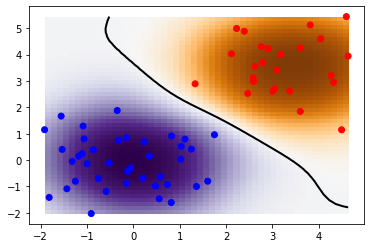

In [4]:
indx, (X,labels) = next(enumerate(test_dataset))

X,labels = X.cpu(), labels.cpu()
colors = ['r' if val > 0 else 'b' for val in labels]
plt.scatter(X[:,0], X[:,1], c=colors)

xlower, xupper, ylower, yupper = min(X[:,0]), max(X[:,0]), min(X[:,1]), max(X[:,1])
xx, yy = np.meshgrid(np.linspace(xlower, xupper, 50),
                     np.linspace(ylower, yupper, 50))

# Take the meshgrid of points and extract probability values
Z = clf.predict_proba(torch.Tensor(np.vstack((xx.ravel(), yy.ravel())).T).to(clf.device))

# Put the predicted values into the right shape
Z = Z.cpu().reshape(xx.shape)


plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2,
                           colors=['k'])

It looks really good! But now let's try it on MNIST

### Experimenting with MNIST

Because I want to just stick with a binary classifier, we have to convert the 10-digit problem to a 0/1 problem. I'll do something quite trivial here: if the digit is < 5 then we'll label it 0, otherwise its label is 1.

Also, you'll noticed i'm flattening a 28x28 dataset to 784 for simplicity.

In [6]:
batch_size_train = 128
batch_size_test = 1000

class FlattenTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return img.view(self.new_size)

class BinarizeLabel:
    def __init__(self):
        pass
    
    def __call__(self,trgt):
        return 1 if trgt > 4 else -1

mnist_train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               FlattenTransform(784)
                             ]),
                              target_transform = BinarizeLabel()),
  batch_size=batch_size_train, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               FlattenTransform(784)
                             ]),
                              target_transform = BinarizeLabel()),
  batch_size=batch_size_test, shuffle=True)


### Performance on MNIST

The behavior is a bit weird. It seems to bring the error down, but then it goes back up. This could be regularization. Mostly I feel like we should be getting better performance overall. It's also very sensitive to parameters, which is maybe the big issue. But maybe someone can make this better?

In [11]:
clfmnist = KernelClassifier(784,kernel='gaussian',lmbda=0.01,eta=0.2,budget=2048,gamma=0.01)
clfmnist.train(mnist_train_loader,test_loader=mnist_test_loader,num_epochs=5)


Test set: Avg. loss: 0.6931, Error: 0.5000

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.642456
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.603550
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.598319
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.607370
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.599127
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.595349
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.595758
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.605306
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.597696
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.609670
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.604006
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.597989
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.597057
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.595461
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.603347
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.596433
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.584865
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.596614
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.596924
Train Epoch: 1 [24320